<a href="https://colab.research.google.com/github/Allen-1022/Allen-1022/blob/main/SmartyStocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Start from AI Subsystem 1: Demand Forecasting using Random Forest

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [ ]:
# Upload dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("cleaned_inventory_data.csv")

Saving cleaned_inventory_data.csv to cleaned_inventory_data (1).csv


In [ ]:
# Drop leakage column
if "Demand Forecast" in df.columns:
    df = df.drop(columns=["Demand Forecast"])

In [ ]:
# Ensure no negative values
df = df[df["Inventory_Level"] >= 0]
df = df[df["Units_Sold"] >= 0]

In [ ]:
# Temporal Ordering
df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" +
                            df["Month"].astype(str) + "-01")

df = df.sort_values("Date").reset_index(drop=True)

In [ ]:
# Feature Engineering: Lag Feature
df["Units_Sold_Lag1"] = df["Units_Sold"].shift(1)
df = df.dropna().reset_index(drop=True)

In [ ]:
# Encode Categorical Variables
categorical_cols = ["Category", "Region", "Weather Condition", "Seasonality"]

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# Define Features and target
target = "Units_Sold"

features = [
    "Inventory_Level",
    "Units_Ordered",
    "Price",
    "Discount",
    "Competitor_Pricing",
    "Holiday_Promotion",
    "Category",
    "Region",
    "Weather Condition",
    "Seasonality",
    "Year",
    "Month",
    "Units_Sold_Lag1"
]

X = df[features]
y = df[target]

In [ ]:
# Time-Based Train & Test Split
split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
# Train Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
# Prediction & Evaluation
rf_predictions = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("Random Forest MAE:", rf_mae)
print("Random Forest RMSE:", rf_rmse)

Random Forest MAE: 69.22369699042409
Random Forest RMSE: 88.95998534513154


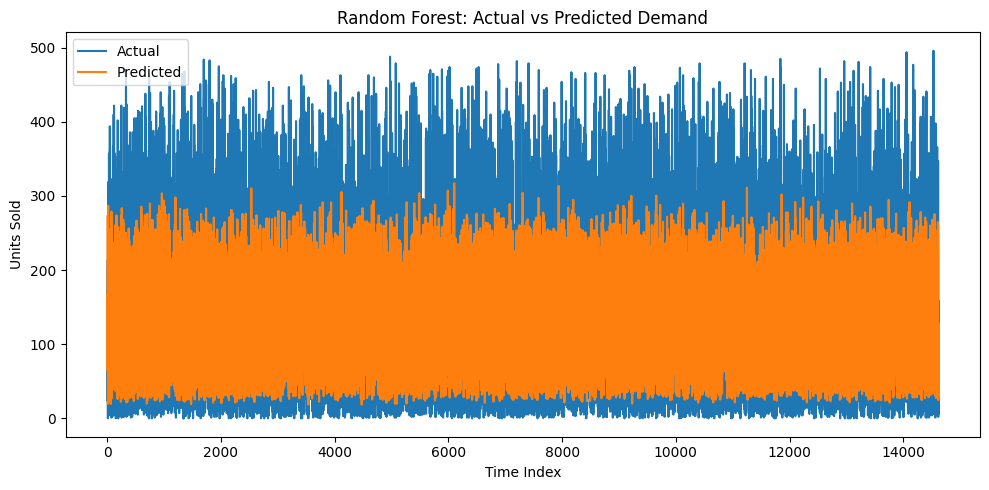

In [ ]:
# Plot the results
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual")
plt.plot(rf_predictions, label="Predicted")
plt.title("Random Forest: Actual vs Predicted Demand")
plt.xlabel("Time Index")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Reorder Decision Logic
results_rf = X_test.copy()
results_rf["Actual_Demand"] = y_test.values
results_rf["Predicted_Demand"] = rf_predictions

results_rf["Reorder_Flag"] = results_rf["Predicted_Demand"] > results_rf["Inventory_Level"]
results_rf["Reorder_Quantity"] = np.maximum(
    results_rf["Predicted_Demand"] - results_rf["Inventory_Level"], 0
)

results_rf["Priority"] = pd.cut(
    results_rf["Reorder_Quantity"],
    bins=[-1, 10, 50, np.inf],
    labels=["Low", "Medium", "High"]
)

results_rf.head()

,Inventory_Level,Units_Ordered,Price,Discount,Competitor_Pricing,Holiday_Promotion,Category,Region,Weather Condition,Seasonality,Year,Month,Units_Sold_Lag1,Actual_Demand,Predicted_Demand,Reorder_Flag,Reorder_Quantity,Priority
58479,187,23,27.98,0,27.10,0,2,2,2,0,2023,8,68.0,96,94.91,False,0.0,Low
58480,225,81,27.44,15,31.64,1,0,3,1,1,2023,8,96.0,124,120.42,False,0.0,Low
58481,229,52,59.32,20,56.07,0,3,1,2,0,2023,8,124.0,173,121.48,False,0.0,Low
58482,170,107,63.41,10,67.92,1,0,2,1,1,2023,8,173.0,27,90.00,False,0.0,Low
58483,217,141,87.11,5,85.70,0,1,3,0,3,2023,8,27.0,24,78.26,False,0.0,Low


In [ ]:
# Another method for Subsystem 1 using Prophet

In [ ]:
%pip install prophet
from prophet import Prophet

In [ ]:
# Prepare Prophet Dataset
prophet_df = df[["Date", "Units_Sold", "Price", "Discount"]].copy()
prophet_df.columns = ["ds", "y", "Price", "Discount"]

In [ ]:
# Time-Based Split (MATCH RF)
train_prophet = prophet_df.iloc[:split_index]
test_prophet = prophet_df.iloc[split_index:]

In [ ]:
# Initialise Prophet Model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

prophet_model.add_regressor("Price")
prophet_model.add_regressor("Discount")

In [ ]:
# Start Training
prophet_model.fit(train_prophet)

In [ ]:
# Forecast
future = test_prophet[["ds", "Price", "Discount"]]
forecast = prophet_model.predict(future)

prophet_predictions = forecast["yhat"].values

In [ ]:
# Evaluate Prophet Method
prophet_mae = mean_absolute_error(test_prophet["y"], prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(test_prophet["y"], prophet_predictions))

print("Prophet MAE:", prophet_mae)
print("Prophet RMSE:", prophet_rmse)

Prophet MAE: 88.61682260768497
Prophet RMSE: 108.42054525284819


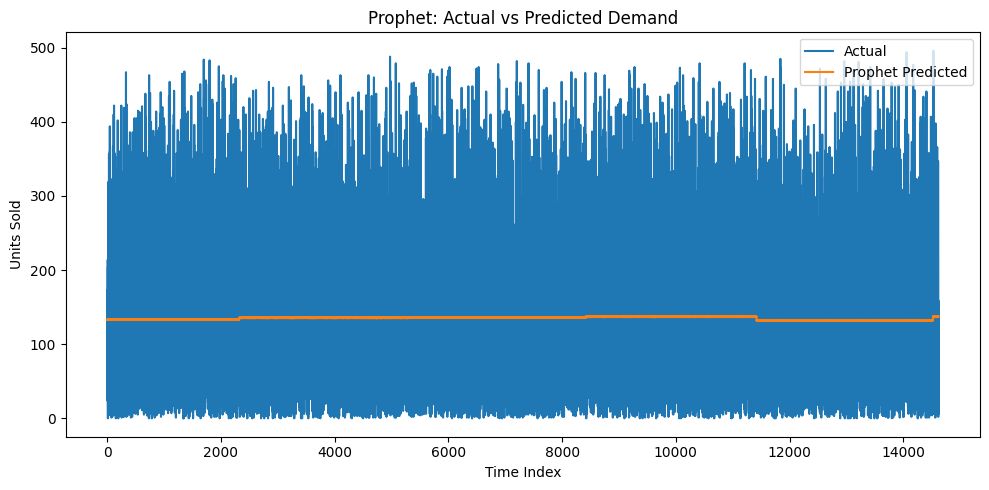

In [ ]:
# Plot the results
plt.figure(figsize=(10,5))
plt.plot(test_prophet["y"].values, label="Actual")
plt.plot(prophet_predictions, label="Prophet Predicted")
plt.title("Prophet: Actual vs Predicted Demand")
plt.xlabel("Time Index")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Comparison between Random Forest and Prophet
comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "Prophet"],
    "MAE": [rf_mae, prophet_mae],
    "RMSE": [rf_rmse, prophet_rmse]
})

comparison_df

,Model,MAE,RMSE
0,Random Forest,69.223697,88.959985
1,Prophet,88.616823,108.420545


In [ ]:
# Subsystem 2 : Inventory Decision Engine using Fuzzy Logic

In [ ]:
%pip install scikit-fuzzy

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [ ]:
# Define Fuzzy inputs & outputs
predicted_demand = ctrl.Antecedent(np.arange(0, 501, 1), 'predicted_demand')
inventory_level = ctrl.Antecedent(np.arange(0, 501, 1), 'inventory_level')

reorder_quantity = ctrl.Consequent(np.arange(0, 401, 1), 'reorder_quantity')
priority = ctrl.Consequent(np.arange(0, 101, 1), 'priority')

In [ ]:
# Membership Functions
predicted_demand['low'] = fuzz.trimf(predicted_demand.universe, [0, 0, 200])
predicted_demand['medium'] = fuzz.trimf(predicted_demand.universe, [100, 250, 400])
predicted_demand['high'] = fuzz.trimf(predicted_demand.universe, [300, 500, 500])

inventory_level['low'] = fuzz.trimf(inventory_level.universe, [0, 0, 200])
inventory_level['medium'] = fuzz.trimf(inventory_level.universe, [100, 250, 400])
inventory_level['high'] = fuzz.trimf(inventory_level.universe, [300, 500, 500])

reorder_quantity['none'] = fuzz.trimf(reorder_quantity.universe, [0, 0, 50])
reorder_quantity['small'] = fuzz.trimf(reorder_quantity.universe, [20, 100, 200])
reorder_quantity['large'] = fuzz.trimf(reorder_quantity.universe, [150, 300, 400])

priority['low'] = fuzz.trimf(priority.universe, [0, 0, 40])
priority['medium'] = fuzz.trimf(priority.universe, [30, 50, 70])
priority['high'] = fuzz.trimf(priority.universe, [60, 100, 100])

In [ ]:
# Define Fuzzy Rules for our system
rule1 = ctrl.Rule(predicted_demand['high'] & inventory_level['low'],
                  (reorder_quantity['large'], priority['high']))

rule2 = ctrl.Rule(predicted_demand['medium'] & inventory_level['low'],
                  (reorder_quantity['small'], priority['medium']))

rule3 = ctrl.Rule(predicted_demand['low'] & inventory_level['high'],
                  (reorder_quantity['none'], priority['low']))

rule4 = ctrl.Rule(predicted_demand['medium'] & inventory_level['medium'],
                  (reorder_quantity['small'], priority['medium']))

rule5 = ctrl.Rule(predicted_demand['high'] & inventory_level['medium'],
                  (reorder_quantity['large'], priority['high']))

In [ ]:
# Build Control System
inventory_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
inventory_simulator = ctrl.ControlSystemSimulation(inventory_ctrl)

In [ ]:
# System Testing
inventory_simulator.input['predicted_demand'] = 380
inventory_simulator.input['inventory_level'] = 120

inventory_simulator.compute()

print("Reorder Quantity:", inventory_simulator.output['reorder_quantity'])
print("Priority Level:", inventory_simulator.output['priority'])

Reorder Quantity: 245.33716475095753
Priority Level: 74.64945380518748


In [ ]:
test_cases = [
    (80, 400),
    (90, 250),
    (220, 100),
    (260, 240),
    (380, 120),
    (410, 260),
    (200, 420),
    (450, 430)
]

for demand, inventory in test_cases:
    inventory_simulator.input['predicted_demand'] = demand
    inventory_simulator.input['inventory_level'] = inventory
    inventory_simulator.compute()

    reorder = inventory_simulator.output.get('reorder_quantity', np.nan)
    priority_val = inventory_simulator.output.get('priority', np.nan)

    print(f"Demand={demand}, Inventory={inventory} → "
          f"Reorder={reorder:.1f}, "
          f"Priority={priority_val:.1f}")

Demand=80, Inventory=400 → Reorder=19.4, Priority=15.6
Demand=90, Inventory=250 → Reorder=nan, Priority=nan
Demand=220, Inventory=100 → Reorder=107.8, Priority=50.0
Demand=260, Inventory=240 → Reorder=106.7, Priority=50.0
Demand=380, Inventory=120 → Reorder=245.3, Priority=74.6
Demand=410, Inventory=260 → Reorder=281.0, Priority=84.8
Demand=200, Inventory=420 → Reorder=nan, Priority=nan
Demand=450, Inventory=430 → Reorder=nan, Priority=nan
